In [1]:
import re
import os
import sys
import pprint

from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text

assin_idx = [[55, 60], [65, 70], [152, 157], [173, 177]]
tweetsent_idx = [[6, 12], [22, 27], [33, 38], [45, 50]]
LEGEND_TITLE = 'Training set'
BBOX_TO_ANCHOR = 2.5

assin_metrics = [
    'Accuracy',
    'Macro F1',
    'Pearson',
    'Mean Squared Error',
]

tweetsent_metrics = [
    'Accuracy',
    'F1. neg',
    'F1. neu',
    'F1. pos',
]

def is_assin(task_name: str):
    return 'assin' in task_name


def get_idx(task: str, assin: bool):
    idx = assin_idx if assin else tweetsent_idx

    return idx


def get_float(string: str, float_pos: List[int]):
    start, end = float_pos[0], float_pos[1]
    float_num = string[start:end]
    float_num = float(float_num)

    return float_num


def get_metric_name(metric_idx: int, assin: bool):
    metrics_names = assin_metrics if assin else tweetsent_metrics
    metric_name = metrics_names[metric_idx]

    return metric_name


def get_metric(task: str, task_name: str, metric_idx: int) -> tuple:
    task_idx = get_idx(task, is_assin(task_name))[metric_idx]
    metric = get_float(task, task_idx)

    return metric


def get_evals(report: str, task_name: str, model_set: set):
    tasks = re.split('corpus.*|Saving generated XMLs...', report)
    tasks = [task for task in tasks
             if f'{task_name}_eval.txt' in task and any(model in task for model in model_set)]

    evals = {model: dict() for model in model_set}
    pattern = re.compile(
        r'report/(.*?)/(.*?)/.*/dropout/\d+\.\d+(/*.*)/.*?txt')
    for task in tasks:
        mode, model, extra = re.search(pattern, task).groups()
        evals[model].update({mode + extra: task})

    return evals


def get_report(filepath: str):
    with open(filepath) as f:
        report = f.read()
        report = re.sub('\n\n\n\n*', '\n\n', report)

    return report


def get_scores_dict(filepath: str, model_set: set, task_name: str, metric_idx: int, models_lang: str, cabezudo: bool):
    report = get_report(filepath)
    evals = get_evals(report, task_name, model_set)
    scores = dict()

    if task_name.startswith('assin-') and models_lang == 'pt':
        cabezudo_approaches = {
            'st-dnn/assin1-rte',
            'st-dnn/best-pt',
            'st-dnn/random-pt',
            'st-dnn/worst-pt',
        }

        approaches = set(list(evals.values())[0].keys())
        remove_approaches = cabezudo_approaches if metric_idx >= 2 or cabezudo == False else approaches - cabezudo_approaches

        for model in evals:
            for approach in remove_approaches:
                evals[model].pop(approach)

    for model in evals:
        scores[model] = {key: get_metric(value, task_name, metric_idx)
                         for key, value in evals[model].items()}

    return scores


def get_models_scores_dict(files: List[str], model_set: set, task_name: str, metric_idx: int, models_lang: str, cabezudo: bool):
    scores_dict_lst = [get_scores_dict(filepath, model_set, task_name, metric_idx, models_lang, cabezudo)
                       for filepath in files]

    models_scores_dict = dict()
    for model in model_set:
        models_scores_dict[model] = [scores[model]
                                     for scores in scores_dict_lst]

    return models_scores_dict

def get_data(task_name: str, models_lang: str, metric_idx: int, cabezudo: bool):
    path = 'report/seed'
    models = {
        'en': {
            'mt-dnn_base',
            'bert_base',
            'bert_large',
            'mt-dnn_large',
        },
        'pt': {
            'bert-multilingual_base',
            'bert-pt_base',
            'bert-pt_large',
        }
    }

    metric_idx = int(metric_idx)
    model_set = models[models_lang]

    pattern = re.compile(r'\d\d\d\d_.*_.*.txt')
    files = [f'{path}/{filename}' for filename in os.listdir(
        path) if re.search(pattern, filename)]
    models_scores_dict = get_models_scores_dict(
        files, model_set, task_name, metric_idx, models_lang, cabezudo)
    return models_scores_dict

def rename_columns(list_of_dicts, rename_dict):
    return pd.DataFrame(list_of_dicts).rename(columns=rename_dict).to_dict('records')
    

In [2]:

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['axes.linewidth'] = 2.0
plt.rcParams['axes.edgecolor'] = 'black'

def assin1_ptbr_plotting(destination='test.png'):
    # assin 1 ptbr

    assin1_ptbr_data_pt = get_data('assin-ptbr', 'pt', num, False)
    assin1_ptbr_data_en = get_data('assin-ptbr', 'en', num, False) 

    assin_type = 'RTE' if num in [0, 1] else 'STS'

    rename_dict_1 = {'st-dnn': 'ASSIN 1 PTBR ' + assin_type + ' (only)',
       'mt-dnn_assin': 'ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2',
       'mt-dnn_assin+tweetsent': 'ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2 + TweetSentBR',
       'mt-dnn_assin-ptbr+assin2': 'ASSIN 1 PTBR + ASSIN 2',
       'st-dnn/assin-1+2': 'ASSIN 1 PTBR, ASSIN 1 PTPT and ASSIN 2, merged',
       'st-dnn/assin-ptbr+2': 'ASSIN 1 PTBR and ASSIN 2, merged'}
    for key in assin1_ptbr_data_pt.keys():
        assin1_ptbr_data_pt[key] = rename_columns(assin1_ptbr_data_pt[key], rename_dict_1)

    rename_dict_2 = {
        'st-dnn': 'ASSIN 1 PTBR ' + assin_type + ' (only)', 
        'mt-dnn_assin': 'ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2', 
        'mt-dnn_assin+tweetsent': 'ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2 + TweetSentBR'
    }
    for key in assin1_ptbr_data_en.keys():
        if 'mt-dnn' not in key:
            assin1_ptbr_data_en[key] = rename_columns(assin1_ptbr_data_en[key], rename_dict_2)

    rename_dict_3 = {
        'st-dnn': 'GLUE + ASSIN 1 PTBR ' + assin_type + ' (only)', 
        'mt-dnn_assin': 'GLUE + ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2', 
        'mt-dnn_assin+tweetsent': 'GLUE + ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2 + TweetSentBR'
    }
    for key in assin1_ptbr_data_en.keys():
        if 'mt-dnn' in key:
            assin1_ptbr_data_en[key] = rename_columns(assin1_ptbr_data_en[key], rename_dict_3)

    rename_models_dict = {
        "bert-pt_base": "$\mathregular{PT-BERT_{BASE}}$",
        "bert-multilingual_base": "$\mathregular{BERT-multilingual_{CASED}}$",
        "bert-pt_large": "$\mathregular{PT-BERT_{LARGE}}$",
        "mt-dnn_large": "$\mathregular{BERT_{LARGE}}$",
        "bert_base": "$\mathregular{BERT_{BASE}}$",
        "mt-dnn_base": "$\mathregular{BERT_{BASE}}$",
        "bert_large": "$\mathregular{BERT_{LARGE}}$"
    }

    def rename_keys(models_dict, input_dict):
        input_keys_list = [ k for k in models_dict.keys() if k in input_dict.keys() ]
        for key in input_keys_list:
            input_dict[models_dict[key]] = input_dict.pop(key)
        return input_dict

    assin1_ptbr_data_pt = rename_keys(rename_models_dict, assin1_ptbr_data_pt)
    assin1_ptbr_data_en = rename_keys(rename_models_dict, assin1_ptbr_data_en)

    from collections import defaultdict
    def merge_keys(a,b):
        de = defaultdict(list, a)
        for i, j in b.items():
            de[i].extend(j)
        return dict(de)

    final_plot = merge_keys(assin1_ptbr_data_pt, assin1_ptbr_data_en)

    def flatten_dict(dct):
        df = []
        key_collection = []
        for key in dct.keys():
            for item in dct[key]:
                for item_key in item.keys():
                    key_collection.append(item_key)
        key_collection = sorted(list(set(key_collection)))
        key_collection_dict = { v:k for k,v in enumerate(key_collection) }
        for key_idx, key in enumerate(dct.keys()):
            for item in dct[key]:
                for item_key in item.keys():
                    row = {
                        "key": item_key,
                        YAXIS_LABEL: item[item_key],
                        "numeric_key": key_collection_dict[item_key],
                        "model": key,
                        "model_key": key_idx
                    }
                    df.append(row)
        return pd.DataFrame(df)

    final_plot = flatten_dict(final_plot)

    ## Plotting

    fig, axes = plt.subplots(1, 5)
    for i in range(5):
        g = sns.boxplot(x="numeric_key", y=YAXIS_LABEL, data=final_plot[final_plot['model_key']==i], orient='v', ax=axes[i], color='white')
        g.set_title(final_plot[final_plot['model_key']==i].sample()['model'].values.tolist()[0])
        # iterate over boxes
        for i,box in enumerate(g.artists):
            box.set_edgecolor('black')
            box.set_facecolor('white')

            # iterate over whiskers and median lines
            for j in range(6*i,6*(i+1)):
                 g.lines[j].set_color('black')

    plt.tight_layout()

    for g in fig.axes:
        g.axes.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        g.axes.set_xlabel('')
        g.axes.xaxis.grid(True)

    for idx, item in enumerate(fig.axes):
        if idx:
            fig.axes[idx].yaxis.set_ticklabels([])
            fig.axes[idx].set_ylabel('')
        fig.axes[idx].set_ylim(min_y, max_y)

    plt.subplots_adjust(wspace=0, hspace=0)

    def adjust_legend(graphs, labels, handle_text, bbox_to_anchor_x=1.0, bbox_to_anchor_y=1.0):
        class TextHandler(HandlerBase):
            def create_artists(self, legend, tup, xdescent, ydescent,
                               width, height, fontsize, trans):
                tx = Text(
                    width/2.,
                    height/2,
                    tup[0],
                    fontsize=fontsize,
                    ha="center",
                    va="center",
                    # color=tup[1],
                    # fontweight="bold",
                    alpha=1,
                )
                return [tx]

        for graph in graphs:
    #         graph.set_xticklabels(handle_text)
            pass

        handles = []
        for idx, item in enumerate(labels):
            handles.append((idx, (0.0, 0.0, 0.0, 1)))
    #         handles.extend([(l, a.get_facecolor())
    #                    for l, a in zip(handle_text, graphs[idx].artists)])

        lgd = graph.legend(handles,
                     labels,
                     bbox_to_anchor=(bbox_to_anchor_x, bbox_to_anchor_y),
                     handler_map={tuple: TextHandler()},
                     title=LEGEND_TITLE
                     )
        return lgd

    def get_legend_labels(final_plot):
        value_dict = {}
        values = [ {x['numeric_key'] : x['key']} for x in final_plot.to_dict('records') ]
        for item in values:
            for dct_item in item.items():
                value_dict[dct_item[0]] = dct_item[1]        
        value_dict = sorted(value_dict.items(), key=lambda x: x[0])
        value_dict = dict(value_dict)
        return list(value_dict.values()), list(value_dict.keys())

    lgd = adjust_legend(fig.axes, *get_legend_labels(final_plot), bbox_to_anchor_x=BBOX_TO_ANCHOR_X, bbox_to_anchor_y=BBOX_TO_ANCHOR_Y)
    
    plt.savefig(destination, bbox_extra_artists=(lgd,), bbox_inches='tight')

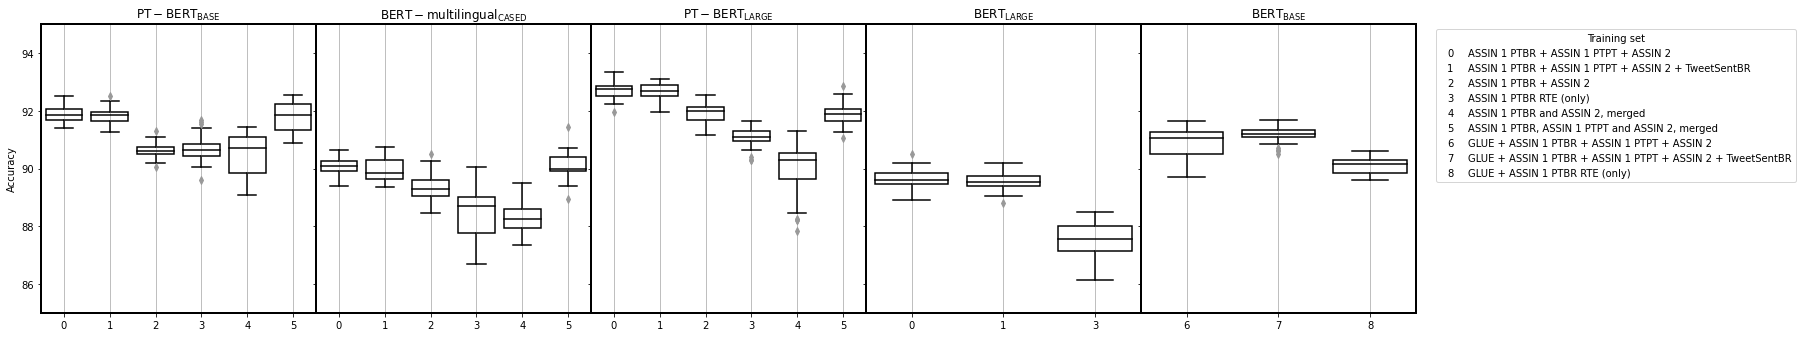

In [3]:
num = 0
min_y = 85
max_y = 95
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
YAXIS_LABEL='Accuracy'
assin1_ptbr_plotting(destination='./boxplot/black_and_white/assin1_ptbr_rte_acc.png')

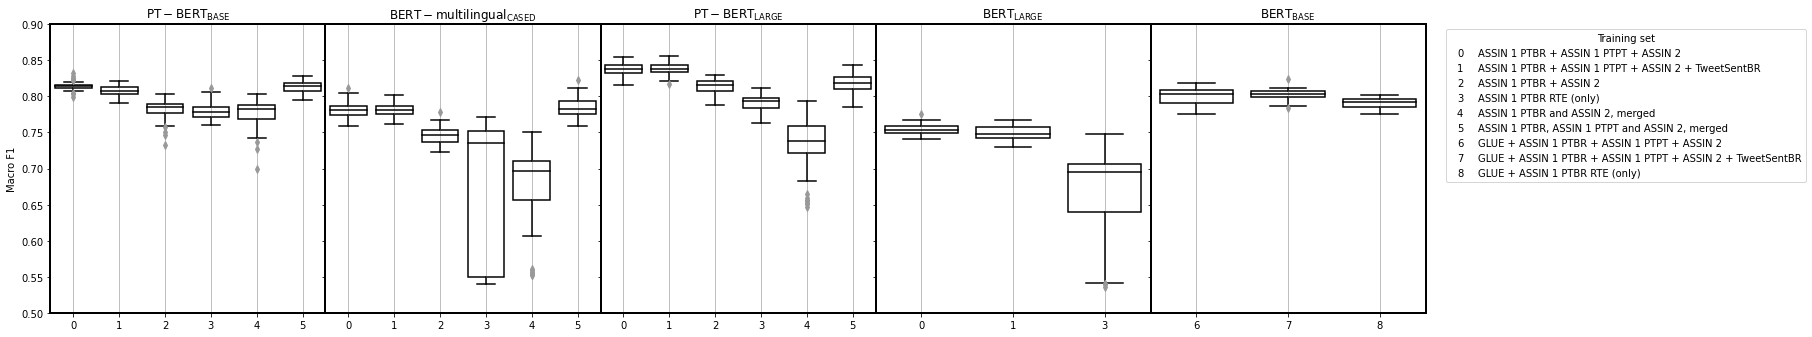

In [4]:
num = 1
min_y = 0.5
max_y = 0.90
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
YAXIS_LABEL='Macro F1'
assin1_ptbr_plotting(destination='./boxplot/black_and_white/assin1_ptbr_rte_f1.png')

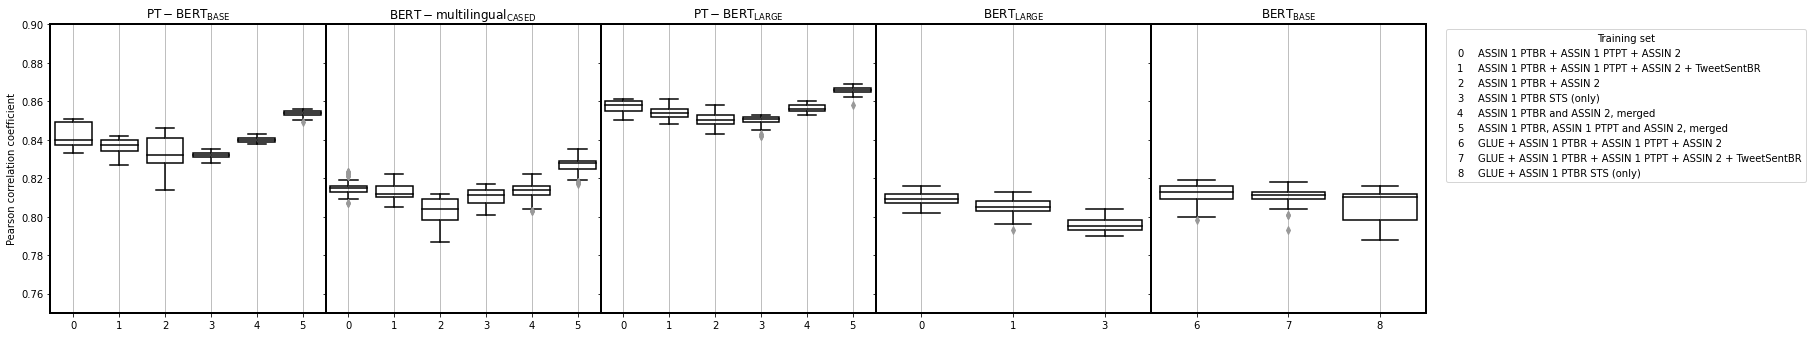

In [5]:
num = 2
min_y = 0.75
max_y = 0.90
YAXIS_LABEL='Pearson correlation coefficient'
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
assin1_ptbr_plotting('./boxplot/black_and_white/assin1_ptbr_sts_pearson.png')

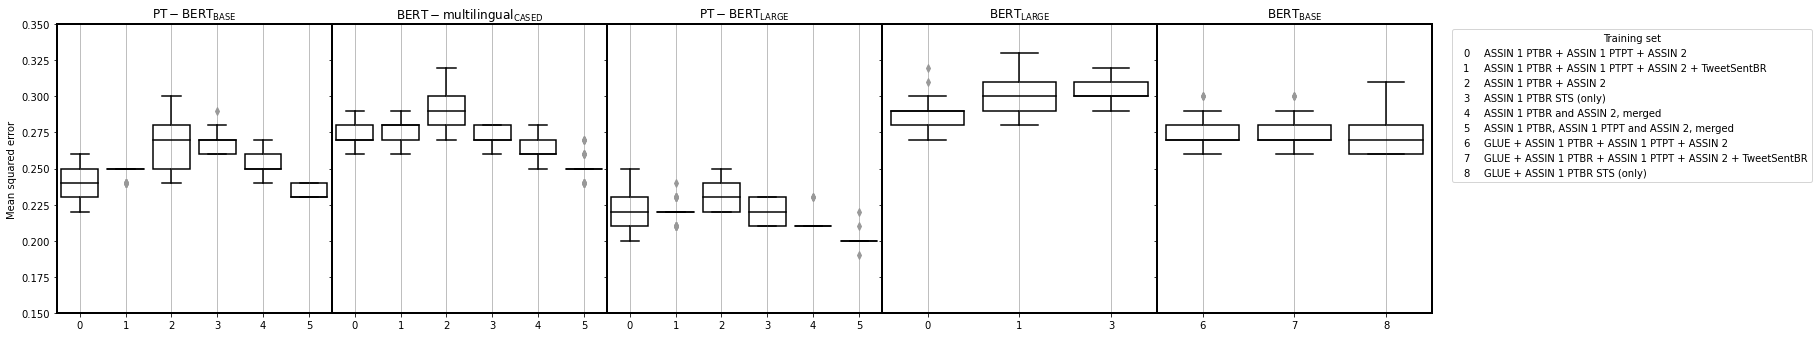

In [6]:
num = 3
min_y = 0.15
max_y = 0.35
YAXIS_LABEL='Mean squared error'
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
assin1_ptbr_plotting('./boxplot/black_and_white/assin1_ptbr_sts_mse.png')

In [7]:
def assin1_ptpt_plotting(destination=None):
    # assin 1 ptpt

    data_pt = get_data('assin-ptpt', 'pt', num, False)
    data_en = get_data('assin-ptpt', 'en', num, False)

    assin_type = 'RTE' if num in [0, 1] else STS

    rename_dict_1 = {'st-dnn': 'ASSIN 1 PTPT ' + assin_type + ' (only)',
       'mt-dnn_assin': 'ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2',
       'mt-dnn_assin+tweetsent': 'ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2 + TweetSentBR',
       'st-dnn/assin-1+2': 'ASSIN 1 PTBR, ASSIN 1 PTPT and ASSIN 2, merged'
    }
    for key in data_pt.keys():
        data_pt[key] = rename_columns(data_pt[key], rename_dict_1)

    rename_dict_2 = {'st-dnn': 'ASSIN 1 PTPT ' + assin_type + ' (only)',
       'mt-dnn_assin': 'ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2',
       'mt-dnn_assin+tweetsent': 'ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2 + TweetSentBR'
    }
    for key in data_en.keys():
        if 'mt-dnn' not in key:
            data_en[key] = rename_columns(data_en[key], rename_dict_2)

    rename_dict_3 = {
        'st-dnn': 'GLUE + ASSIN 1 PTPT ' + assin_type + ' (only)', 
        'mt-dnn_assin': 'GLUE + ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2', 
        'mt-dnn_assin+tweetsent': 'GLUE + ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2 + TweetSentBR'
    }
    for key in data_en.keys():
        if 'mt-dnn' in key:
            data_en[key] = rename_columns(data_en[key], rename_dict_3)

    rename_models_dict = {
        "bert-pt_base": "$\mathregular{PT-BERT_{BASE}}$",
        "bert-multilingual_base": "$\mathregular{BERT-multilingual_{CASED}}$",
        "bert-pt_large": "$\mathregular{PT-BERT_{LARGE}}$",
        "mt-dnn_large": "$\mathregular{BERT_{LARGE}}$",
        "bert_base": "$\mathregular{BERT_{BASE}}$",
        "mt-dnn_base": "$\mathregular{BERT_{BASE}}$",
        "bert_large": "$\mathregular{BERT_{LARGE}}$"
    }

    def rename_keys(models_dict, input_dict):
        input_keys_list = [ k for k in models_dict.keys() if k in input_dict.keys() ]
        for key in input_keys_list:
            input_dict[models_dict[key]] = input_dict.pop(key)
        return input_dict

    data_pt = rename_keys(rename_models_dict, data_pt)
    data_en = rename_keys(rename_models_dict, data_en)

    from collections import defaultdict
    def merge_keys(a,b):
        de = defaultdict(list, a)
        for i, j in b.items():
            de[i].extend(j)
        return dict(de)

    final_plot = merge_keys(data_pt, data_en)

    def flatten_dict(dct):
        df = []
        key_collection = []
        for key in dct.keys():
            for item in dct[key]:
                for item_key in item.keys():
                    key_collection.append(item_key)
        key_collection = sorted(list(set(key_collection)))
        key_collection_dict = { v:k for k,v in enumerate(key_collection) }
        for key_idx, key in enumerate(dct.keys()):
            for item in dct[key]:
                for item_key in item.keys():
                    row = {
                        "key": item_key,
                        YAXIS_LABEL: item[item_key],
                        "numeric_key": key_collection_dict[item_key],
                        "model": key,
                        "model_key": key_idx
                    }
                    df.append(row)
        return pd.DataFrame(df)

    final_plot = flatten_dict(final_plot)

    ## Plotting

    fig, axes = plt.subplots(1, 5)
    for i in range(5):
        g = sns.boxplot(x="numeric_key", y=YAXIS_LABEL, data=final_plot[final_plot['model_key']==i], orient='v', ax=axes[i], color='white')
        g.set_title(final_plot[final_plot['model_key']==i].sample()['model'].values.tolist()[0])
        # iterate over boxes
        for i,box in enumerate(g.artists):
            box.set_edgecolor('black')
            box.set_facecolor('white')

            # iterate over whiskers and median lines
            for j in range(6*i,6*(i+1)):
                 g.lines[j].set_color('black')

    plt.tight_layout()

    for g in fig.axes:
        g.axes.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        g.axes.set_xlabel('')
        g.axes.xaxis.grid(True)

    for idx, item in enumerate(fig.axes):
        if idx:
            fig.axes[idx].yaxis.set_ticklabels([])
            fig.axes[idx].set_ylabel('')
        fig.axes[idx].set_ylim(min_y, max_y)

    plt.subplots_adjust(wspace=0, hspace=0)

    def adjust_legend(graphs, labels, handle_text, bbox_to_anchor_x=1.0, bbox_to_anchor_y=1.0):
        class TextHandler(HandlerBase):
            def create_artists(self, legend, tup, xdescent, ydescent,
                               width, height, fontsize, trans):
                tx = Text(
                    width/2.,
                    height/2,
                    tup[0],
                    fontsize=fontsize,
                    ha="center",
                    va="center",
                    # color=tup[1],
                    # fontweight="bold",
                    alpha=1,
                )
                return [tx]

        for graph in graphs:
    #         graph.set_xticklabels(handle_text)
            pass

        handles = []
        for idx, item in enumerate(labels):
            handles.append((idx, (0.0, 0.0, 0.0, 1)))
    #         handles.extend([(l, a.get_facecolor())
    #                    for l, a in zip(handle_text, graphs[idx].artists)])

        lgd = graph.legend(handles,
                     labels,
                     bbox_to_anchor=(bbox_to_anchor_x, bbox_to_anchor_y),
                     handler_map={tuple: TextHandler()},
                     title=LEGEND_TITLE
                     )
        return lgd

    def get_legend_labels(final_plot):
        value_dict = {}
        values = [ {x['numeric_key'] : x['key']} for x in final_plot.to_dict('records') ]
        for item in values:
            for dct_item in item.items():
                value_dict[dct_item[0]] = dct_item[1]        
        value_dict = sorted(value_dict.items(), key=lambda x: x[0])
        value_dict = dict(value_dict)
        return list(value_dict.values()), list(value_dict.keys())

    lgd = adjust_legend(fig.axes, *get_legend_labels(final_plot), bbox_to_anchor_x=BBOX_TO_ANCHOR_X, bbox_to_anchor_y=BBOX_TO_ANCHOR_Y)
    
    plt.savefig(destination, bbox_extra_artists=(lgd,), bbox_inches='tight')

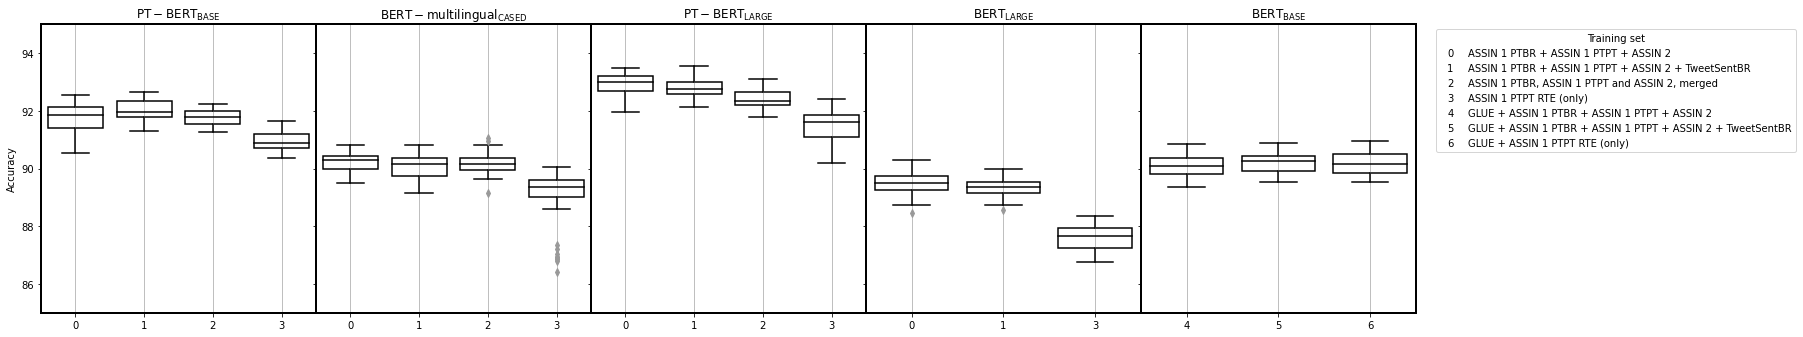

In [8]:
num = 0
min_y = 85
max_y = 95
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
YAXIS_LABEL='Accuracy'
assin1_ptpt_plotting(destination='./boxplot/black_and_white/assin1_ptpt_rte_acc.png')

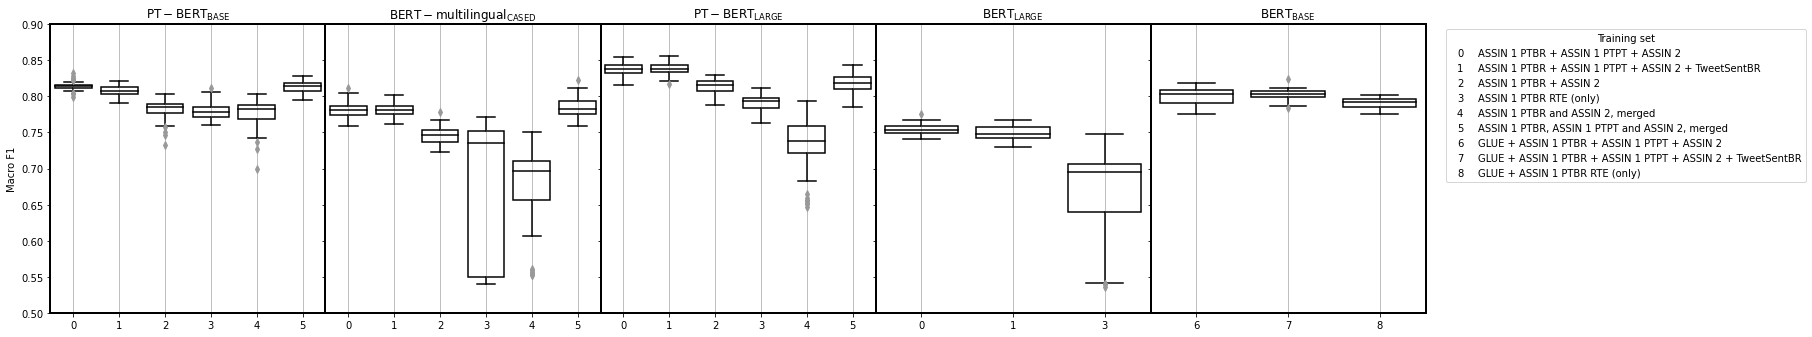

In [9]:
num = 1
min_y = 0.5
max_y = 0.90
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
YAXIS_LABEL='Macro F1'
assin1_ptbr_plotting(destination='./boxplot/black_and_white/assin1_ptpt_rte_f1.png')

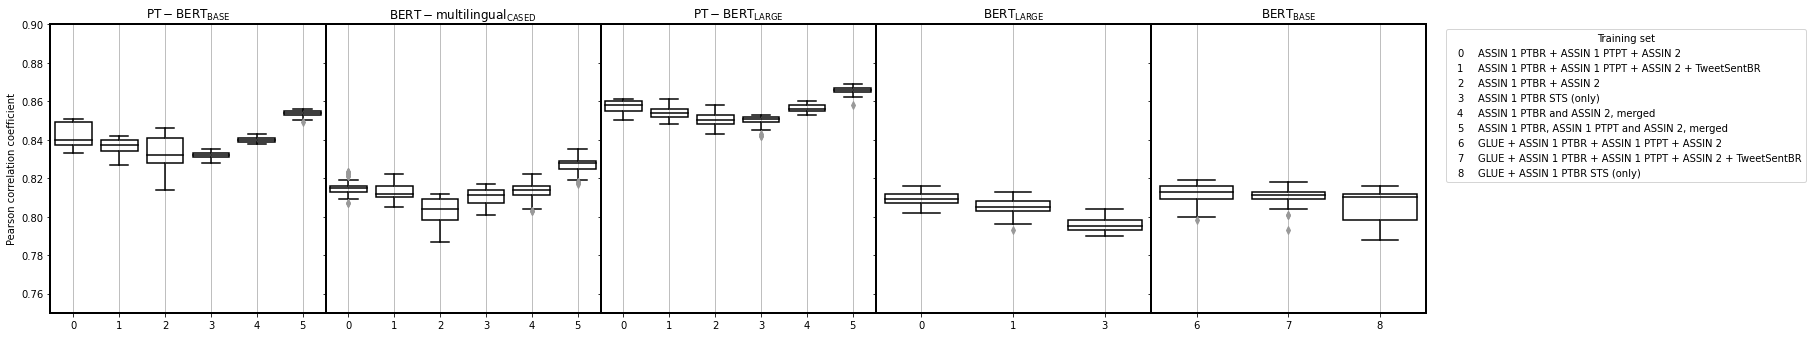

In [10]:
num = 2
min_y = 0.75
max_y = 0.90
YAXIS_LABEL='Pearson correlation coefficient'
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
assin1_ptbr_plotting('./boxplot/black_and_white/assin1_ptpt_sts_pearson.png')

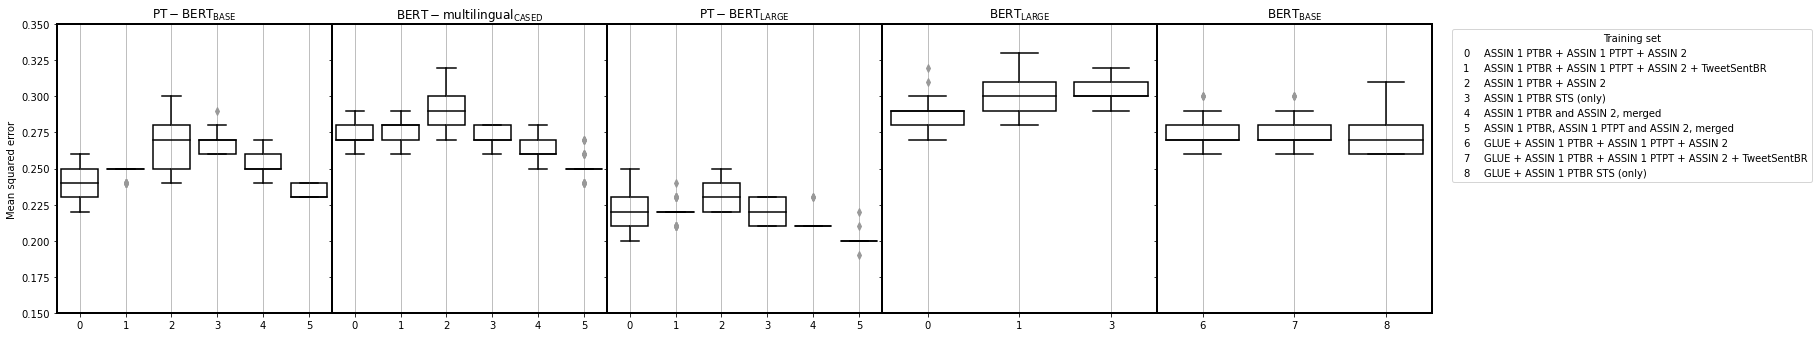

In [11]:
num = 3
min_y = 0.15
max_y = 0.35
YAXIS_LABEL='Mean squared error'
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
assin1_ptbr_plotting('./boxplot/black_and_white/assin1_ptpt_sts_mse.png')

In [12]:
def assin2_plotting(destination=None):
    # assin 2

    data_pt = get_data('assin2', 'pt', num, False)
    data_en = get_data('assin2', 'en', num, False)

    assin_type = 'RTE' if num in [0, 1] else 'STS'

    rename_dict_1 =  {'st-dnn': 'ASSIN 2' + assin_type + ' (only)',
       'mt-dnn_assin': 'ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2',
       'mt-dnn_assin2': 'ASSIN 2',
       'mt-dnn_assin+tweetsent': 'ASSIN 1 PTPT + ASSIN 1 PTBR + ASSIN 2 + TweetSentBR',
       'mt-dnn_assin-ptbr+assin2': 'ASSIN 1 PTPT + ASSIN 2',
       'st-dnn/assin-1+2': 'ASSIN 1 PTBR, ASSIN 1 PTPT and ASSIN 2, merged',
       'st-dnn/assin-ptbr+2': 'ASSIN 1 PTBR and ASSIN 2, merged'}
    for key in data_pt.keys():
        data_pt[key] = rename_columns(data_pt[key], rename_dict_1)

    rename_dict_2 = {'st-dnn': 'ASSIN 2 ' + assin_type + ' (only)',
       'mt-dnn_assin': 'ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2',
       'mt-dnn_assin+tweetsent': 'ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2 + TweetSentBR'
    }
    for key in data_en.keys():
        if 'mt-dnn' not in key:
            data_en[key] = rename_columns(data_en[key], rename_dict_2)

    rename_dict_3 = {
        'st-dnn': 'GLUE + ASSIN 1 PTPT ' + assin_type + ' (only)', 
        'mt-dnn_assin': 'GLUE + ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2', 
        'mt-dnn_assin+tweetsent': 'GLUE + ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2 + TweetSentBR'
    }
    for key in data_en.keys():
        if 'mt-dnn' in key:
            data_en[key] = rename_columns(data_en[key], rename_dict_3)

    rename_models_dict = {
        "bert-pt_base": "$\mathregular{PT-BERT_{BASE}}$",
        "bert-multilingual_base": "$\mathregular{BERT-multilingual_{CASED}}$",
        "bert-pt_large": "$\mathregular{PT-BERT_{LARGE}}$",
        "mt-dnn_large": "$\mathregular{BERT_{LARGE}}$",
        "bert_base": "$\mathregular{BERT_{BASE}}$",
        "mt-dnn_base": "$\mathregular{BERT_{BASE}}$",
        "bert_large": "$\mathregular{BERT_{LARGE}}$"
    }

    def rename_keys(models_dict, input_dict):
        input_keys_list = [ k for k in models_dict.keys() if k in input_dict.keys() ]
        for key in input_keys_list:
            input_dict[models_dict[key]] = input_dict.pop(key)
        return input_dict

    data_pt = rename_keys(rename_models_dict, data_pt)
    data_en = rename_keys(rename_models_dict, data_en)

    from collections import defaultdict
    def merge_keys(a,b):
        de = defaultdict(list, a)
        for i, j in b.items():
            de[i].extend(j)
        return dict(de)

    final_plot = merge_keys(data_pt, data_en)

    def flatten_dict(dct):
        df = []
        key_collection = []
        for key in dct.keys():
            for item in dct[key]:
                for item_key in item.keys():
                    key_collection.append(item_key)
        key_collection = sorted(list(set(key_collection)))
        key_collection_dict = { v:k for k,v in enumerate(key_collection) }
        for key_idx, key in enumerate(dct.keys()):
            for item in dct[key]:
                for item_key in item.keys():
                    row = {
                        "key": item_key,
                        YAXIS_LABEL: item[item_key],
                        "numeric_key": key_collection_dict[item_key],
                        "model": key,
                        "model_key": key_idx
                    }
                    df.append(row)
        return pd.DataFrame(df)

    final_plot = flatten_dict(final_plot)

    ## Plotting

    fig, axes = plt.subplots(1, 5)
    for i in range(5):
        g = sns.boxplot(x="numeric_key", y=YAXIS_LABEL, data=final_plot[final_plot['model_key']==i], orient='v', ax=axes[i], color='white')
        g.set_title(final_plot[final_plot['model_key']==i].sample()['model'].values.tolist()[0])
        # iterate over boxes
        for i,box in enumerate(g.artists):
            box.set_edgecolor('black')
            box.set_facecolor('white')

            # iterate over whiskers and median lines
            for j in range(6*i,6*(i+1)):
                 g.lines[j].set_color('black')

    plt.tight_layout()

    for g in fig.axes:
        g.axes.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        g.axes.set_xlabel('')
        g.axes.xaxis.grid(True)

    for idx, item in enumerate(fig.axes):
        if idx:
            fig.axes[idx].yaxis.set_ticklabels([])
            fig.axes[idx].set_ylabel('')
        fig.axes[idx].set_ylim(min_y, max_y)

    plt.subplots_adjust(wspace=0, hspace=0)

    def adjust_legend(graphs, labels, handle_text, bbox_to_anchor_x=1.0, bbox_to_anchor_y=1.0):
        class TextHandler(HandlerBase):
            def create_artists(self, legend, tup, xdescent, ydescent,
                               width, height, fontsize, trans):
                tx = Text(
                    width/2.,
                    height/2,
                    tup[0],
                    fontsize=fontsize,
                    ha="center",
                    va="center",
                    # color=tup[1],
                    # fontweight="bold",
                    alpha=1,
                )
                return [tx]

        for graph in graphs:
    #         graph.set_xticklabels(handle_text)
            pass

        handles = []
        for idx, item in enumerate(labels):
            handles.append((idx, (0.0, 0.0, 0.0, 1)))
    #         handles.extend([(l, a.get_facecolor())
    #                    for l, a in zip(handle_text, graphs[idx].artists)])

        lgd = graph.legend(handles,
                     labels,
                     bbox_to_anchor=(bbox_to_anchor_x, bbox_to_anchor_y),
                     handler_map={tuple: TextHandler()},
                     title=LEGEND_TITLE
                     )
        return lgd

    def get_legend_labels(final_plot):
        value_dict = {}
        values = [ {x['numeric_key'] : x['key']} for x in final_plot.to_dict('records') ]
        for item in values:
            for dct_item in item.items():
                value_dict[dct_item[0]] = dct_item[1]        
        value_dict = sorted(value_dict.items(), key=lambda x: x[0])
        value_dict = dict(value_dict)
        return list(value_dict.values()), list(value_dict.keys())

    lgd = adjust_legend(fig.axes, *get_legend_labels(final_plot), bbox_to_anchor_x=BBOX_TO_ANCHOR_X, bbox_to_anchor_y=BBOX_TO_ANCHOR_Y)
    
    plt.savefig(destination, bbox_extra_artists=(lgd,), bbox_inches='tight')

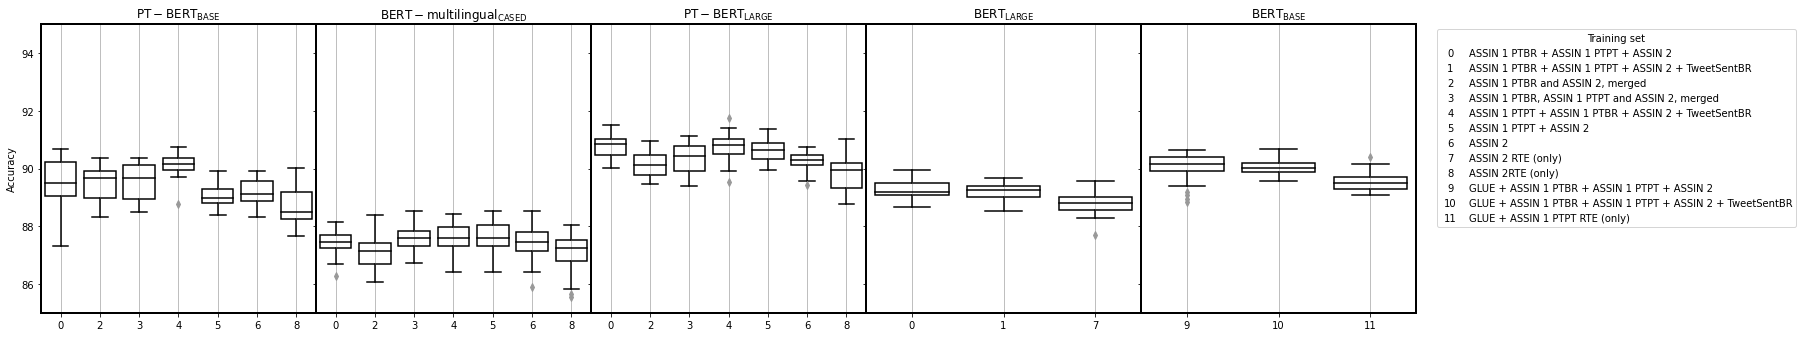

In [13]:
num = 0
min_y = 85
max_y = 95
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
YAXIS_LABEL='Accuracy'
assin2_plotting(destination='./boxplot/black_and_white/assin2_rte_acc.png')

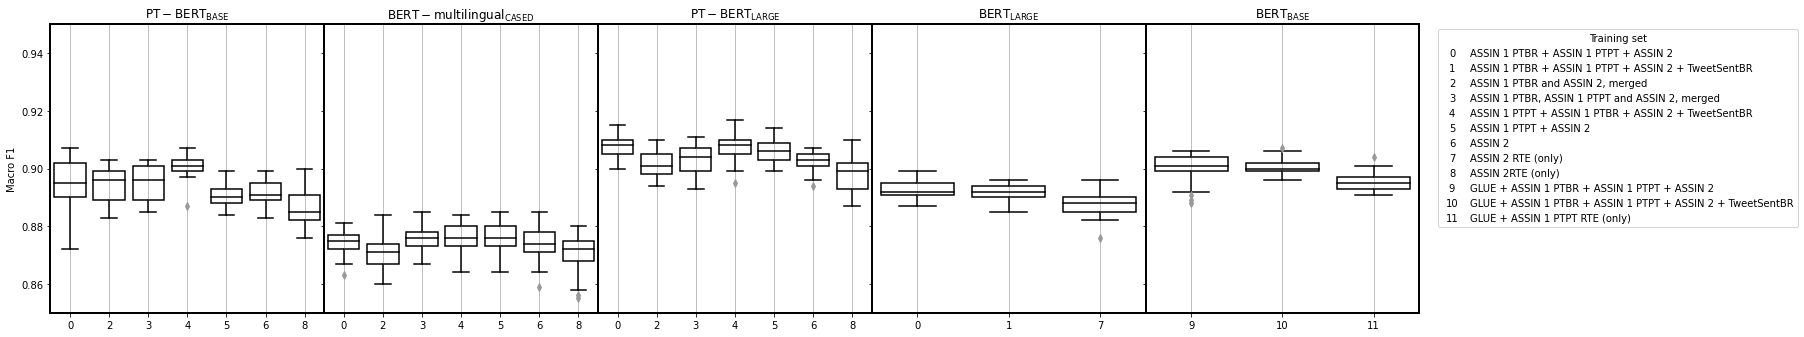

In [14]:
num = 1
min_y = 0.85
max_y = 0.95
YAXIS_LABEL='Macro F1'
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
assin2_plotting(destination='./boxplot/black_and_white/assin2_rte_f1.png')

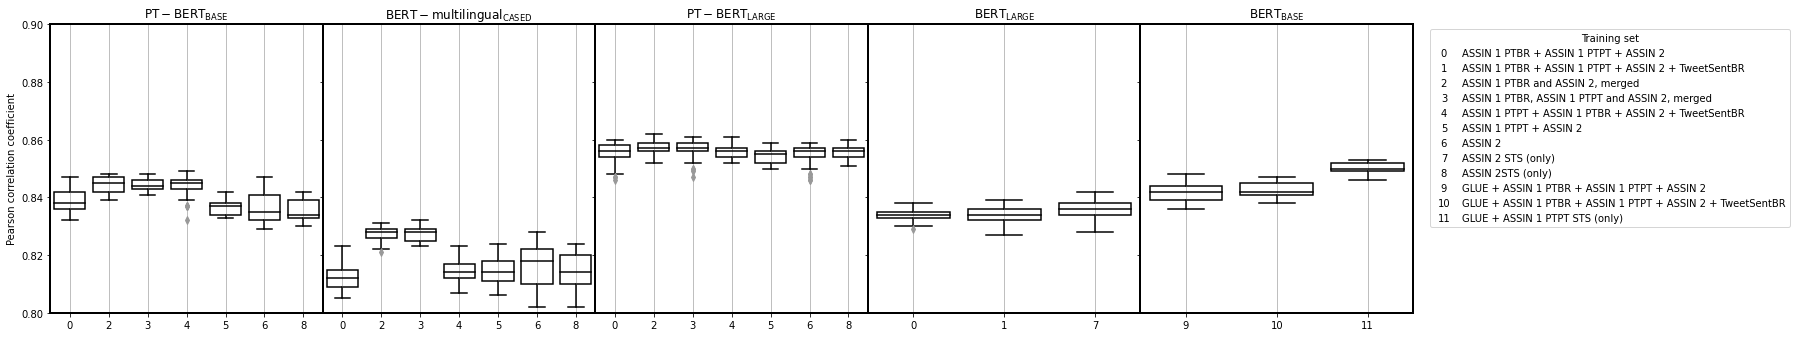

In [15]:
num = 2
min_y = 0.80
max_y = 0.90
YAXIS_LABEL='Pearson correlation coefficient'
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
assin2_plotting('./boxplot/black_and_white/assin2_sts_pearson.png')

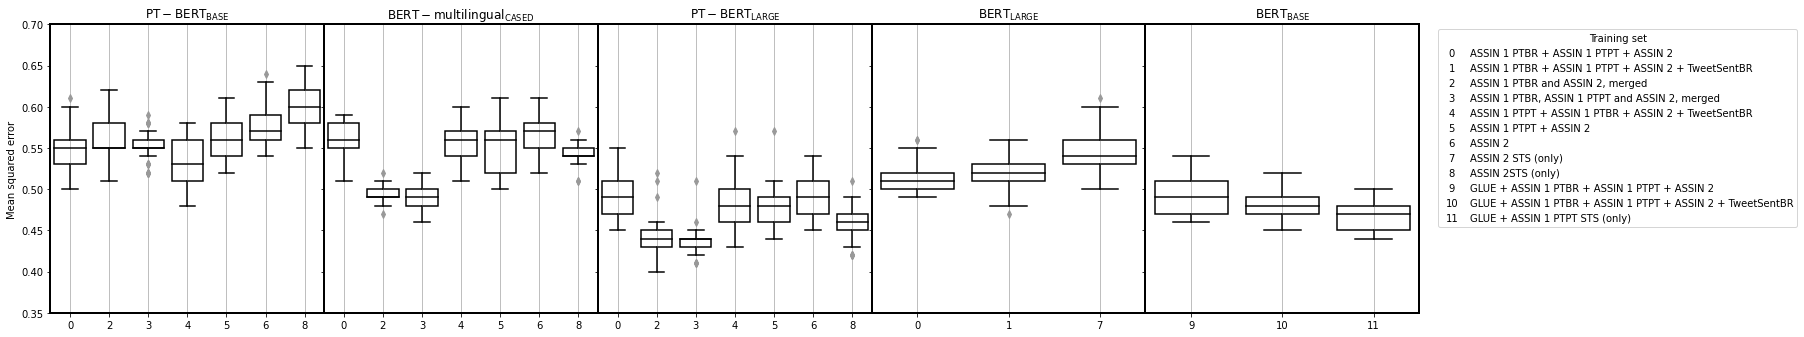

In [16]:
num = 3
min_y = 0.35
max_y = 0.7
YAXIS_LABEL='Mean squared error'
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
assin2_plotting('./boxplot/black_and_white/assin2_sts_mse.png')

In [17]:
def tweetsent_plotting(destination=None):
    # assin 2

    data_pt = get_data('tweetsent', 'pt', num, False)
    data_en = get_data('tweetsent', 'en', num, False)

    rename_dict_1 =  {'st-dnn': 'TweetSentBR',
       'mt-dnn_assin+tweetsent': 'ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2 + TweetSentBR'
        }
    for key in data_pt.keys():
        data_pt[key] = rename_columns(data_pt[key], rename_dict_1)

    rename_dict_2 = {'st-dnn': 'TweetSentBR',
       'mt-dnn_assin+tweetsent': 'ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2 + TweetSentBR'
    }
    for key in data_en.keys():
        if 'mt-dnn' not in key:
            data_en[key] = rename_columns(data_en[key], rename_dict_2)

    rename_dict_3 = {
        'st-dnn': 'GLUE + TweetSentBR', 
        'mt-dnn_assin+tweetsent': 'GLUE + ASSIN 1 PTBR + ASSIN 1 PTPT + ASSIN 2 + TweetSentBR'
    }
    for key in data_en.keys():
        if 'mt-dnn' in key:
            data_en[key] = rename_columns(data_en[key], rename_dict_3)

    rename_models_dict = {
        "bert-pt_base": "$\mathregular{PT-BERT_{BASE}}$",
        "bert-multilingual_base": "$\mathregular{BERT-multilingual_{CASED}}$",
        "bert-pt_large": "$\mathregular{PT-BERT_{LARGE}}$",
        "mt-dnn_large": "$\mathregular{BERT_{LARGE}}$",
        "bert_base": "$\mathregular{BERT_{BASE}}$",
        "mt-dnn_base": "$\mathregular{BERT_{BASE}}$",
        "bert_large": "$\mathregular{BERT_{LARGE}}$"
    }

    def rename_keys(models_dict, input_dict):
        input_keys_list = [ k for k in models_dict.keys() if k in input_dict.keys() ]
        for key in input_keys_list:
            input_dict[models_dict[key]] = input_dict.pop(key)
        return input_dict

    data_pt = rename_keys(rename_models_dict, data_pt)
    data_en = rename_keys(rename_models_dict, data_en)

    from collections import defaultdict
    def merge_keys(a,b):
        de = defaultdict(list, a)
        for i, j in b.items():
            de[i].extend(j)
        return dict(de)

    final_plot = merge_keys(data_pt, data_en)

    def flatten_dict(dct):
        df = []
        key_collection = []
        for key in dct.keys():
            for item in dct[key]:
                for item_key in item.keys():
                    key_collection.append(item_key)
        key_collection = sorted(list(set(key_collection)))
        key_collection_dict = { v:k for k,v in enumerate(key_collection) }
        for key_idx, key in enumerate(dct.keys()):
            for item in dct[key]:
                for item_key in item.keys():
                    row = {
                        "key": item_key,
                        YAXIS_LABEL: item[item_key],
                        "numeric_key": key_collection_dict[item_key],
                        "model": key,
                        "model_key": key_idx
                    }
                    df.append(row)
        return pd.DataFrame(df)

    final_plot = flatten_dict(final_plot)

    ## Plotting

    fig, axes = plt.subplots(1, 5)
    for i in range(5):
        g = sns.boxplot(x="numeric_key", y=YAXIS_LABEL, data=final_plot[final_plot['model_key']==i], orient='v', ax=axes[i], color='white')
        g.set_title(final_plot[final_plot['model_key']==i].sample()['model'].values.tolist()[0])
        # iterate over boxes
        for i,box in enumerate(g.artists):
            box.set_edgecolor('black')
            box.set_facecolor('white')

            # iterate over whiskers and median lines
            for j in range(6*i,6*(i+1)):
                 g.lines[j].set_color('black')

    plt.tight_layout()

    for g in fig.axes:
        g.axes.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        g.axes.set_xlabel('')
        g.axes.xaxis.grid(True)

    for idx, item in enumerate(fig.axes):
        if idx:
            fig.axes[idx].yaxis.set_ticklabels([])
            fig.axes[idx].set_ylabel('')
        fig.axes[idx].set_ylim(min_y, max_y)

    plt.subplots_adjust(wspace=0, hspace=0)

    def adjust_legend(graphs, labels, handle_text, bbox_to_anchor_x=1.0, bbox_to_anchor_y=1.0):
        class TextHandler(HandlerBase):
            def create_artists(self, legend, tup, xdescent, ydescent,
                               width, height, fontsize, trans):
                tx = Text(
                    width/2.,
                    height/2,
                    tup[0],
                    fontsize=fontsize,
                    ha="center",
                    va="center",
                    # color=tup[1],
                    # fontweight="bold",
                    alpha=1,
                )
                return [tx]

        for graph in graphs:
    #         graph.set_xticklabels(handle_text)
            pass

        handles = []
        for idx, item in enumerate(labels):
            handles.append((idx, (0.0, 0.0, 0.0, 1)))
    #         handles.extend([(l, a.get_facecolor())
    #                    for l, a in zip(handle_text, graphs[idx].artists)])

        lgd = graph.legend(handles,
                     labels,
                     bbox_to_anchor=(bbox_to_anchor_x, bbox_to_anchor_y),
                     handler_map={tuple: TextHandler()},
                     title=LEGEND_TITLE
                     )
        return lgd

    def get_legend_labels(final_plot):
        value_dict = {}
        values = [ {x['numeric_key'] : x['key']} for x in final_plot.to_dict('records') ]
        for item in values:
            for dct_item in item.items():
                value_dict[dct_item[0]] = dct_item[1]        
        value_dict = sorted(value_dict.items(), key=lambda x: x[0])
        value_dict = dict(value_dict)
        return list(value_dict.values()), list(value_dict.keys())

    lgd = adjust_legend(fig.axes, *get_legend_labels(final_plot), bbox_to_anchor_x=BBOX_TO_ANCHOR_X, bbox_to_anchor_y=BBOX_TO_ANCHOR_Y)
    
    plt.savefig(destination, bbox_extra_artists=(lgd,), bbox_inches='tight')


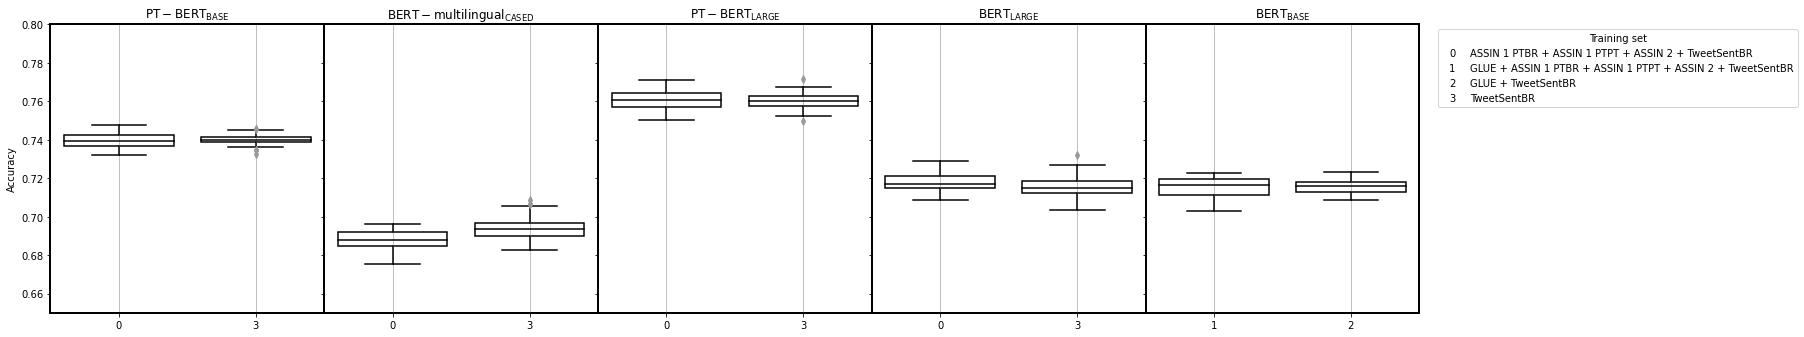

In [18]:
num = 0
min_y = 0.65
max_y = 0.80
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
YAXIS_LABEL='Accuracy'
tweetsent_plotting(destination='./boxplot/black_and_white/tweetsent_acc.png')

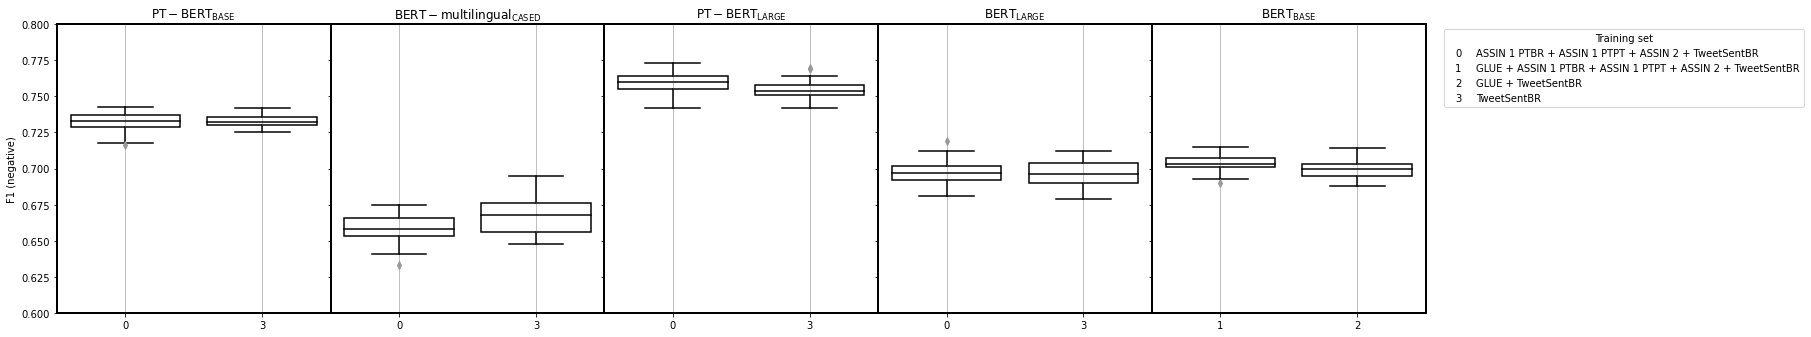

In [19]:
num = 1
min_y = 0.60
max_y = 0.80
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
YAXIS_LABEL='F1 (negative)'
tweetsent_plotting(destination='./boxplot/black_and_white/tweetsent_f1neg.png')

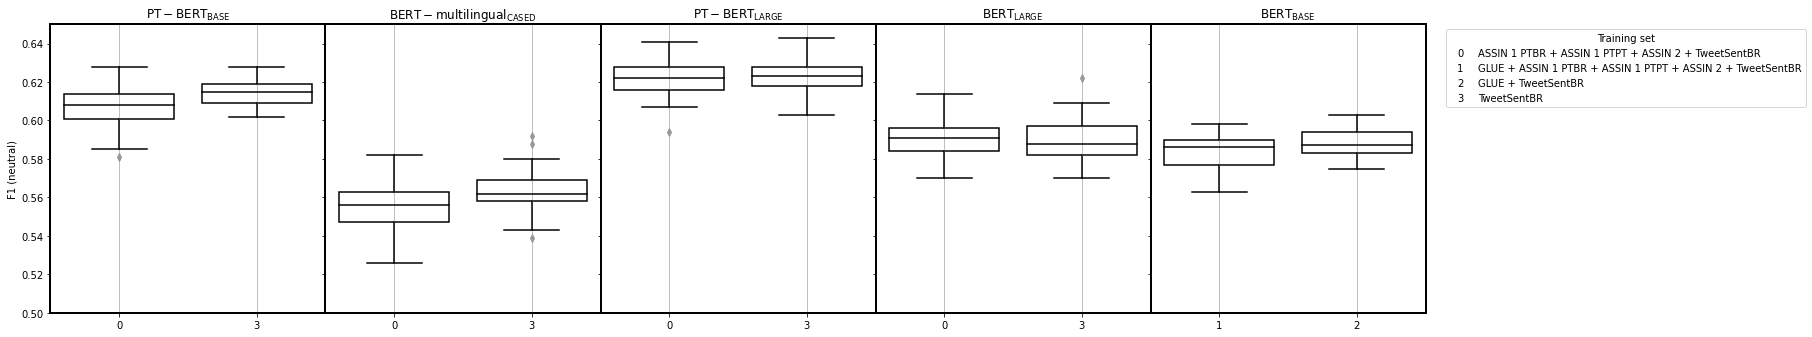

In [20]:
num = 2
min_y = 0.50
max_y = 0.65
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
YAXIS_LABEL='F1 (neutral)'
tweetsent_plotting(destination='./boxplot/black_and_white/tweetsent_f1neu.png')

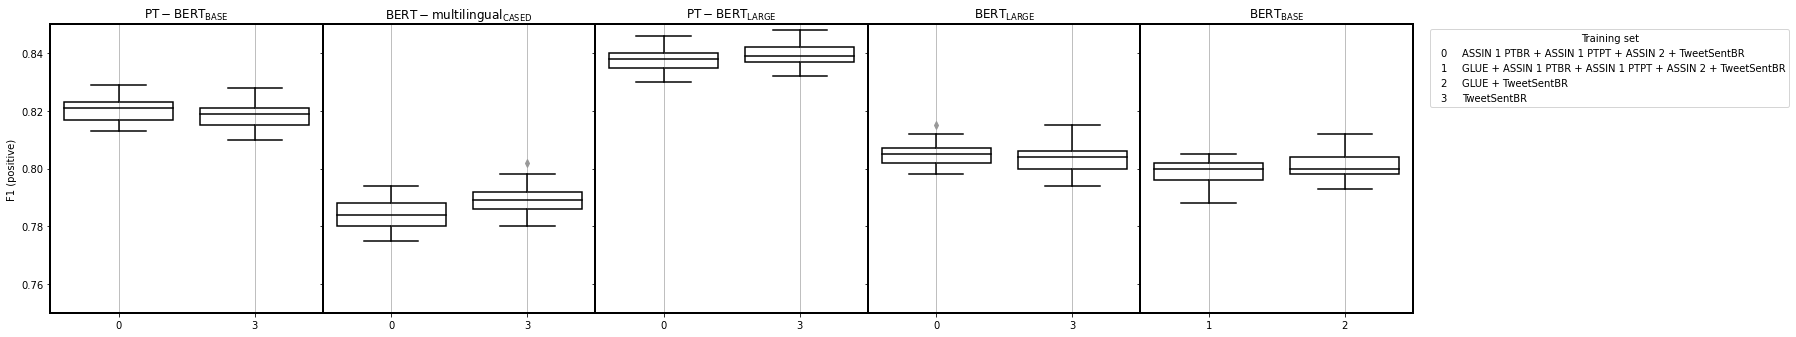

In [21]:
num = 3
min_y = 0.75
max_y = 0.85
BBOX_TO_ANCHOR_X=2.4
BBOX_TO_ANCHOR_Y=1.0
YAXIS_LABEL='F1 (positive)'
tweetsent_plotting(destination='./boxplot/black_and_white/tweetsent_f1pos.png')

In [22]:
def cabezudo_plotting(destination=None):
    # assin 2

    data_pt = get_data('assin-ptbr', 'pt', num, True)

    rename_dict_1 =  {'st-dnn/assin1-rte': 'ASSIN 1 PTBR and ASSIN 1 PTPT, merged',
       'st-dnn/best-pt': 'ASSIN 1 PTBR, ASSIN 1 PTPT and BEST-PT, merged',
       'st-dnn/random-pt': 'ASSIN 1 PTBR, ASSIN 1 PTPT and RANDOM-PT, merged',
       'st-dnn/worst-pt': 'ASSIN 1 PTBR, ASSIN 1 PTPT and WORST-PT, merged'
        }
    for key in data_pt.keys():
        data_pt[key] = rename_columns(data_pt[key], rename_dict_1)

    rename_models_dict = {
        "bert-pt_base": "$\mathregular{PT-BERT_{BASE}}$",
        "bert-multilingual_base": "$\mathregular{BERT-multilingual_{CASED}}$",
        "bert-pt_large": "$\mathregular{PT-BERT_{LARGE}}$"
    }

    def rename_keys(models_dict, input_dict):
        input_keys_list = [ k for k in models_dict.keys() if k in input_dict.keys() ]
        for key in input_keys_list:
            input_dict[models_dict[key]] = input_dict.pop(key)
        return input_dict

    data_pt = rename_keys(rename_models_dict, data_pt)

    from collections import defaultdict
    def merge_keys(a,b):
        de = defaultdict(list, a)
        for i, j in b.items():
            de[i].extend(j)
        return dict(de)

    final_plot = data_pt

    def flatten_dict(dct):
        df = []
        key_collection = []
        for key in dct.keys():
            for item in dct[key]:
                for item_key in item.keys():
                    key_collection.append(item_key)
        key_collection = sorted(list(set(key_collection)))
        key_collection_dict = { v:k for k,v in enumerate(key_collection) }
        for key_idx, key in enumerate(dct.keys()):
            for item in dct[key]:
                for item_key in item.keys():
                    row = {
                        "key": item_key,
                        YAXIS_LABEL: item[item_key],
                        "numeric_key": key_collection_dict[item_key],
                        "model": key,
                        "model_key": key_idx
                    }
                    df.append(row)
        return pd.DataFrame(df)

    final_plot = flatten_dict(final_plot)

    ## Plotting

    fig, axes = plt.subplots(1, 3)
    for i in range(3):
        g = sns.boxplot(x="numeric_key", y=YAXIS_LABEL, data=final_plot[final_plot['model_key']==i], orient='v', ax=axes[i], color='white')
        g.set_title(final_plot[final_plot['model_key']==i].sample()['model'].values.tolist()[0])
        # iterate over boxes
        for i,box in enumerate(g.artists):
            box.set_edgecolor('black')
            box.set_facecolor('white')

            # iterate over whiskers and median lines
            for j in range(6*i,6*(i+1)):
                 g.lines[j].set_color('black')

    plt.tight_layout()

    for g in fig.axes:
        g.axes.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        g.axes.set_xlabel('')
        g.axes.xaxis.grid(True)

    for idx, item in enumerate(fig.axes):
        if idx:
            fig.axes[idx].yaxis.set_ticklabels([])
            fig.axes[idx].set_ylabel('')
        fig.axes[idx].set_ylim(min_y, max_y)

    plt.subplots_adjust(wspace=0, hspace=0)

    def adjust_legend(graphs, labels, handle_text, bbox_to_anchor_x=1.0, bbox_to_anchor_y=1.0):
        class TextHandler(HandlerBase):
            def create_artists(self, legend, tup, xdescent, ydescent,
                               width, height, fontsize, trans):
                tx = Text(
                    width/2.,
                    height/2,
                    tup[0],
                    fontsize=fontsize,
                    ha="center",
                    va="center",
                    # color=tup[1],
                    # fontweight="bold",
                    alpha=1,
                )
                return [tx]

        for graph in graphs:
    #         graph.set_xticklabels(handle_text)
            pass

        handles = []
        for idx, item in enumerate(labels):
            handles.append((idx, (0.0, 0.0, 0.0, 1)))
    #         handles.extend([(l, a.get_facecolor())
    #                    for l, a in zip(handle_text, graphs[idx].artists)])

        lgd = graph.legend(handles,
                     labels,
                     bbox_to_anchor=(bbox_to_anchor_x, bbox_to_anchor_y),
                     handler_map={tuple: TextHandler()},
                     title=LEGEND_TITLE
                     )
        return lgd

    def get_legend_labels(final_plot):
        value_dict = {}
        values = [ {x['numeric_key'] : x['key']} for x in final_plot.to_dict('records') ]
        for item in values:
            for dct_item in item.items():
                value_dict[dct_item[0]] = dct_item[1]        
        value_dict = sorted(value_dict.items(), key=lambda x: x[0])
        value_dict = dict(value_dict)
        return list(value_dict.values()), list(value_dict.keys())

    lgd = adjust_legend(fig.axes, *get_legend_labels(final_plot), bbox_to_anchor_x=BBOX_TO_ANCHOR_X, bbox_to_anchor_y=BBOX_TO_ANCHOR_Y)
    
    plt.savefig(destination, bbox_extra_artists=(lgd,), bbox_inches='tight')


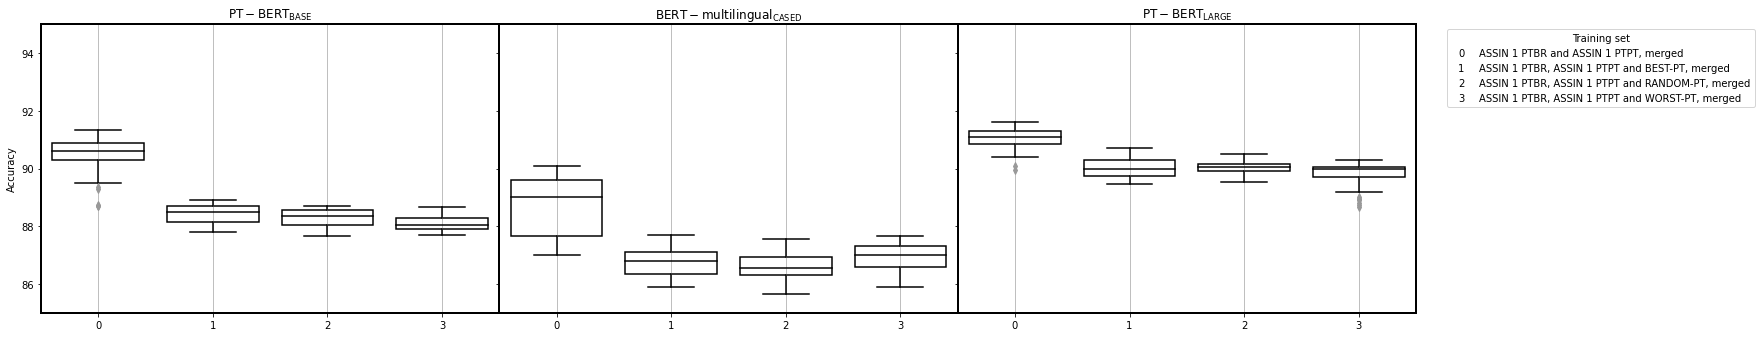

In [23]:
num = 0
min_y = 85
max_y = 95
BBOX_TO_ANCHOR_X=1.75
BBOX_TO_ANCHOR_Y=1.0
YAXIS_LABEL='Accuracy'
cabezudo_plotting(destination='./boxplot/black_and_white/cabezudo_acc.png')

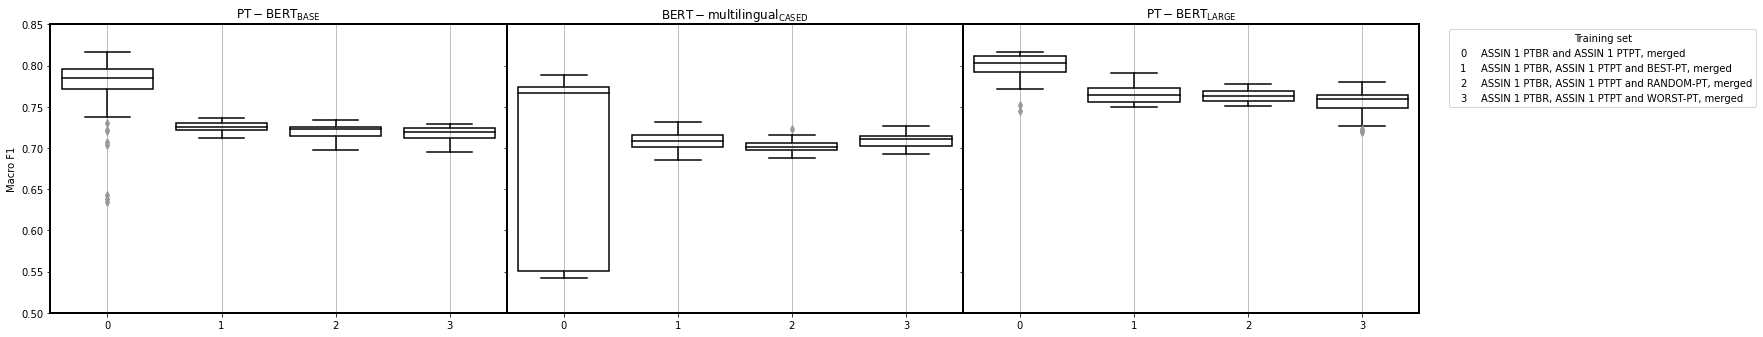

In [24]:
num = 1
min_y = 0.5
max_y = 0.85
BBOX_TO_ANCHOR_X=1.75
BBOX_TO_ANCHOR_Y=1.0
YAXIS_LABEL='Macro F1'
cabezudo_plotting(destination='./boxplot/black_and_white/cabezudo_f1.png')